In [1]:
%pip install -q --upgrade keras tensorflow setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner
print("Successfully installed required packages.")

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%pip install kaggle
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
# !kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
# !unzip chest-xray-masks-and-labels.zip
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf data
# !mv Lung\ Segmentation segmentation_data
# !rm -rf ./segmentation_data/ClinicalReadings
# !rm ./segmentation_data/NLM-ChinaCXRSet-ReadMe.docx
# !rm ./segmentation_data/NLM-MontgomeryCXRSet-ReadMe.pdf
# !mv ./segmentation_data/CXR_png ./segmentation_data/images
!mv TB_Chest_Radiography_Database data

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

split_dir = './data/split'

def split_dataset(base_split_dir='./data/split', normal_dir='./data/Normal', tb_dir='./data/Tuberculosis'):
    train_split = 'train'
    test_split = 'test'
    splits = [train_split, test_split]
    normal_class = 'normal'
    tb_class = 'tuberculosis'
    classes = [normal_class, tb_class]

    normal_files = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
    tb_files = [f for f in os.listdir(tb_dir) if os.path.isfile(os.path.join(tb_dir, f))]

    if os.path.exists(base_split_dir):
        print("Removing existing dataset")
        # If the split directory exists, remove it and so it can be regenerated
        shutil.rmtree(base_split_dir)

    # Split the data into training, test sets
    # The validation set will be created from the training set at a later stage
    train_normal, test_normal = train_test_split(normal_files, test_size=0.1)
    train_tb, test_tb = train_test_split(tb_files, test_size=0.1)

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_split_dir, split, cls), exist_ok=True)

    # Function to copy files to their respective directories
    def copy_files(file_list, dst_dir):
        for file in file_list:
            src_dir = normal_dir if file in normal_files else tb_dir
            shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

    print("Copying train normal set...")
    copy_files(train_normal, os.path.join(base_split_dir, train_split, normal_class))
    print("Copying test normal set...")
    copy_files(test_normal, os.path.join(base_split_dir, test_split, normal_class))

    print("Copying train normal set...")
    copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class))
    print("Copying test normal set...")
    copy_files(test_tb, os.path.join(base_split_dir, test_split, tb_class))

split_dataset(base_split_dir=split_dir)

In [2]:
import keras

split_dir = './data/split'

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

2024-07-23 13:14:44.891048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 13:14:44.899940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 13:14:44.909082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 13:14:44.911890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 13:14:44.921252: I tensorflow/core/platform/cpu_feature_guar

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.


I0000 00:00:1721740486.027323     771 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721740486.031806     771 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721740486.031990     771 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721740486.033790     771 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 420 files belonging to 2 classes.


In [3]:
no_weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

no_weighting_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

no_weighting_history = no_weighting_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

no_weighting_results = no_weighting_model.evaluate(test)
no_weighting_predictions = no_weighting_model.predict(test)

Epoch 1/10


I0000 00:00:1721740487.759818    1033 service.cc:146] XLA service 0x7a5f94007ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721740487.759843    1033 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-23 13:14:47.800240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 13:14:47.912910: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7939 - auc: 0.5556 - f1_score: 0.2928 - loss: 10.1414 - precision: 0.3168 - recall: 0.1958

I0000 00:00:1721740489.768975    1033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8189 - auc: 0.5147 - f1_score: 0.2931 - loss: 3.4197 - precision: 0.3247 - recall: 0.0521 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6597 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8310 - auc: 0.5000 - f1_score: 0.2891 - loss: 0.6512 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8307 - auc: 0.5000 - f1_score: 0.2895 - loss: 0.6245 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8280 - auc: 0.5000 - f1_score: 0.2935 - loss: 0.6

In [4]:
import keras

weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

weighting_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

weighting_history = weighting_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    class_weight={0: 0.2, 1: 1}
)

weighting_results = weighting_model.evaluate(test)
weighting_predictions = weighting_model.predict(test)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6777 - auc_1: 0.4892 - f1_score: 0.2892 - loss: 23.0189 - precision: 0.1628 - recall: 0.2050 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6909 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6653 - auc_1: 0.4945 - f1_score: 0.2913 - loss: 0.2332 - precision: 0.1067 - recall: 0.2348 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6603 - auc_1: 0.4883 - f1_score: 0.2834 - loss: 0.2303 - precision: 0.1053 - recall: 0.2337 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5676 - auc_1: 0.5065 - f1_score: 0.2891 -

2024-07-23 13:15:27.877563: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


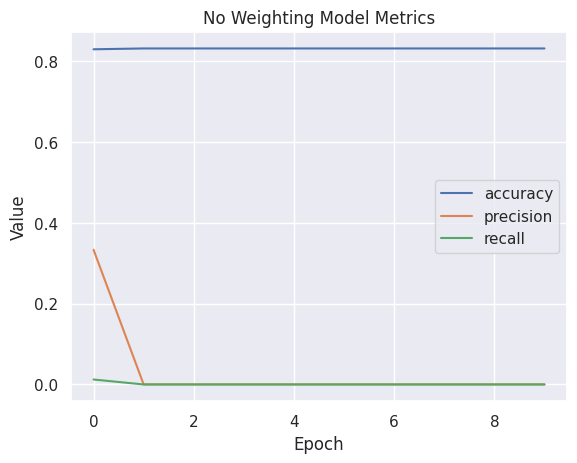

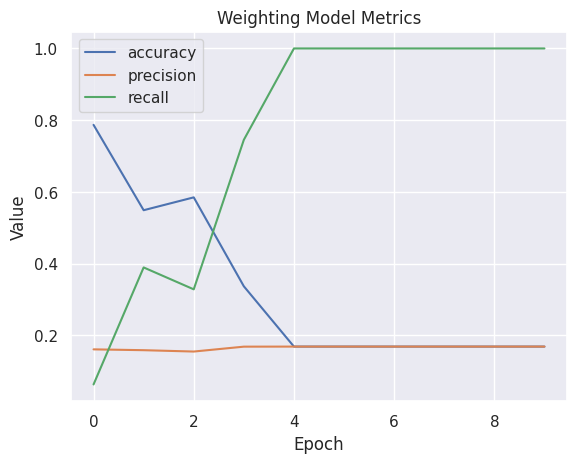

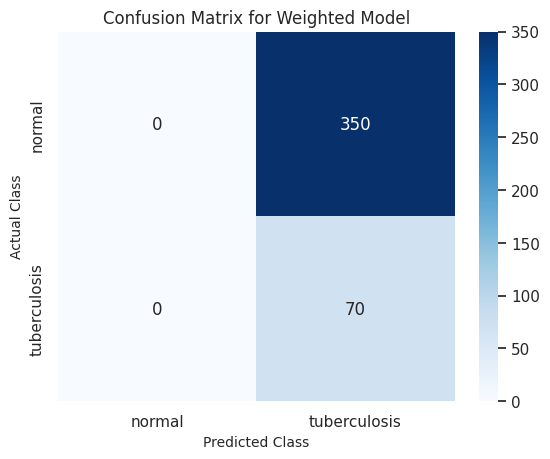

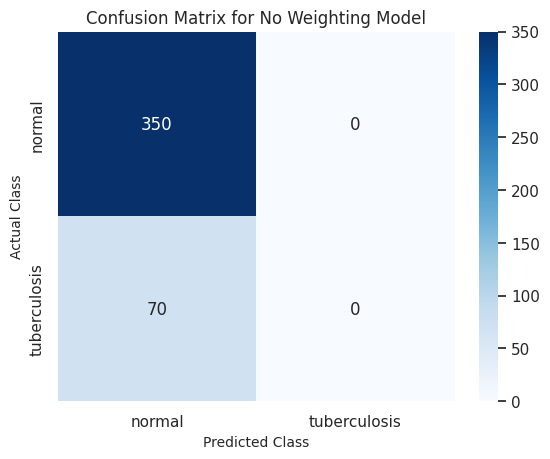

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

sns.set_theme("notebook")

true_y = np.concatenate([y for _, y in test], axis=0).astype(int)
weighted_output = (weighting_predictions > 0.5).astype(int)
no_weighting_output = (no_weighting_predictions > 0.5).astype(int)

# plot the metrics using seaborn
def plot_metrics(history, metrics, title=None):
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(no_weighting_history, ['accuracy', 'precision', 'recall'], title="No Weighting Model Metrics")
plot_metrics(weighting_history, ['accuracy', 'precision', 'recall'], title="Weighting Model Metrics")

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class', fontsize=10)
    plt.ylabel('Actual Class', fontsize=10)
    plt.title(title, fontsize=12)
    plt.show()

plot_confusion_matrix(true_y, weighted_output, ['normal', 'tuberculosis'], title='Confusion Matrix for Weighted Model')
plot_confusion_matrix(true_y, no_weighting_output, ['normal', 'tuberculosis'], title='Confusion Matrix for No Weighting Model')

In [6]:
import keras
import tensorflow as tf
import os

DATA_DIR = "./segmentation_data"
image_dir = os.path.join(DATA_DIR, "images")
mask_dir = os.path.join(DATA_DIR, "masks")

train_masks_dir = os.path.join(DATA_DIR, "train", "masks")
train_images_dir = os.path.join(DATA_DIR, "train", "images")
val_masks_dir = os.path.join(DATA_DIR, "val", "masks")
val_images_dir = os.path.join(DATA_DIR, "val", "images")

train_masks = keras.utils.image_dataset_from_directory(
    train_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_images = keras.utils.image_dataset_from_directory(
    train_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_masks = keras.utils.image_dataset_from_directory(
    val_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_images = keras.utils.image_dataset_from_directory(
    val_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_dataset = tf.data.Dataset.zip((train_images, train_masks))
val_dataset = tf.data.Dataset.zip((val_images, val_masks))

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y / 255.0))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y / 255.0))

Found 633 files.
Found 633 files.
Found 71 files.
Found 71 files.


In [7]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

BACKBONE = 'resnet34'
early_stopper = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

base_model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
)

inp = keras.layers.Input(shape=(256, 256, 1))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)
out = base_model(l1)

model = keras.models.Model(inp, out, name=base_model.name)

model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

history = model.fit(train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopper]
)

Segmentation Models: using `tf.keras` framework.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - f1-score: 0.5653 - iou_score: 0.4033 - loss: 0.4348 - val_f1-score: 0.4226 - val_iou_score: 0.2680 - val_loss: 0.5779
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - f1-score: 0.7480 - iou_score: 0.5979 - loss: 0.2520 - val_f1-score: 0.5490 - val_iou_score: 0.3789 - val_loss: 0.4490
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - f1-score: 0.7716 - iou_score: 0.6286 - loss: 0.2285 - val_f1-score: 0.6841 - val_iou_score: 0.5205 - val_loss: 0.3175
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - f1-score: 0.7807 - iou_score: 0.6408 - loss: 0.2193 - val_f1-score: 0.7493 - val_iou_score: 0.6009 - val_loss: 0.2415
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - f1-score: 0.7857 - iou_score: 0.6477 - loss: 0.2143 - val_f1-score: 0.7599 - val_iou_score: 0.6129 - val_loss: 0.2384


Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


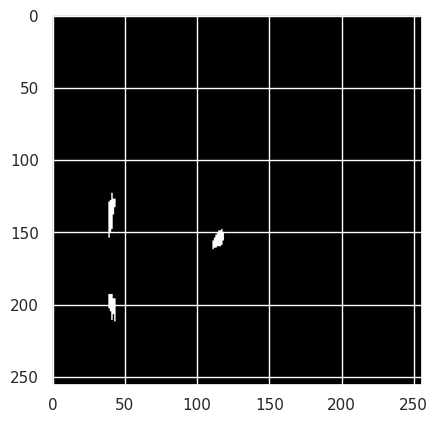

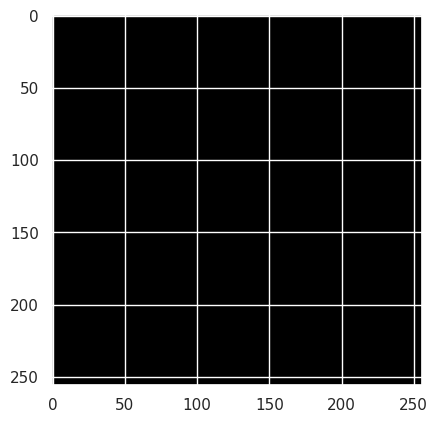

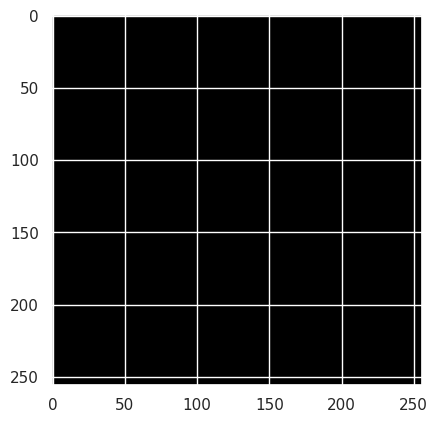

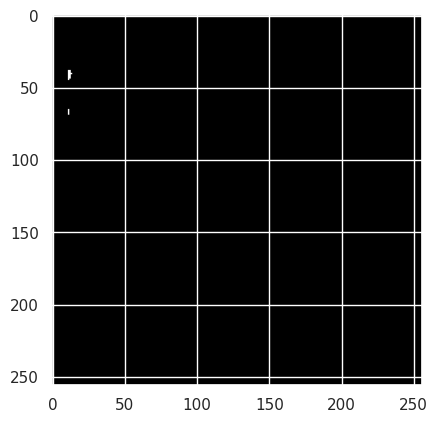

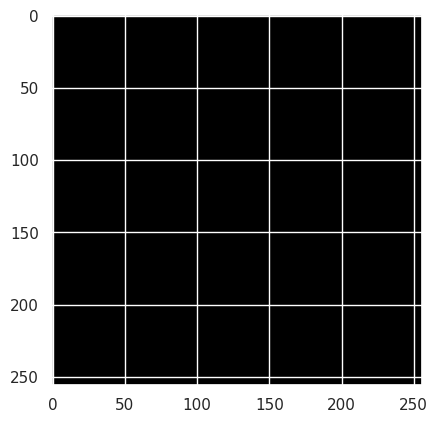

In [8]:
import numpy as np
import matplotlib.pyplot as plt

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


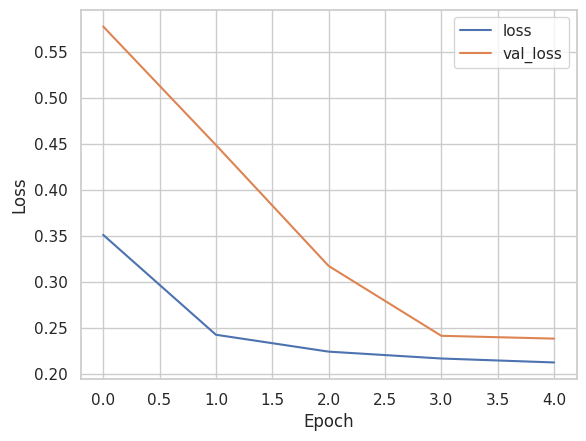

In [9]:
# plot the loss and validation loss using seaborn

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
import shutil

test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

In [11]:
import cv2
import os
import numpy as np

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)
    
    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Developing the Classification Model

### Finding the optimal architecture
This will start with a Grid-Search approach, to find the general direction in which to move. Once that is done a human-directed approach will begin. At this stage it is purely about finding the optimal number of layers and neurons per layer.

At this stage the focus will be on the convolutional layers, while keeping the densely connected layers stable.

In [12]:
import tensorflow as tf
import keras_tuner

def build_model(hp, deterministic=True):
    if deterministic == True:
        tf.keras.utils.set_random_seed(1)

    conv_kernal_size = hp.Choice(name="conv_kernal_size", values=[7, 16, 32])
    pooling_size = hp.Choice(name="pooling_size", values=[2, 4, 8])

    model = keras.models.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.Conv2D(hp.Choice(name="conv_filters", values=[16, 24, 36]), (conv_kernal_size, conv_kernal_size), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(pooling_size, pooling_size)),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dropout(0.6),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.F1Score(name="f1_score"),
            keras.metrics.AUC(num_thresholds=3)
        ]
    )

    return model

In [13]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    mode="auto",
)

tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_same_no_layers"
)

tuner.search(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[cb])

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
7                 |7                 |conv_kernal_size
2                 |2                 |pooling_size
16                |16                |conv_filters

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7915 - auc: 0.4975 - f1_score: 0.2922 - loss: 187.0997 - precision: 0.1541 - recall: 0.0504 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8310 - auc: 0.5000 - f1_score: 0.2890 - loss: 0.6508 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6248 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━

KeyboardInterrupt: 

## Poor results

The grid search yielded very poor results, continuing with a human-directed-search to get to a better starting ground. Here I experiment with a much larger number of filters on the first Convolutional layer

In [14]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

human_dir_1 = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

human_dir_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

history = human_dir_1.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.7719 - auc_1: 0.4771 - f1_score: 0.2679 - loss: 1073.6497 - precision: 0.0722 - recall: 0.0312 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8270 - auc_1: 0.5000 - f1_score: 0.2949 - loss: 0.6584 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6327 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8314 - auc_1: 0.5000 - f1_score: 0.2885 - loss: 0.6294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6

## Still a lack of power

Attempt to increase the number of convolutional & max pooling layer pairs. Using the same values for the filters, filter size, and pooling size for both

In [15]:
import keras

split_dir = './data/split'

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)


human_dir_2 = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

human_dir_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

history = human_dir_2.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8183 - auc_2: 0.5256 - f1_score: 0.2895 - loss: 3.5301 - precision: 0.3336 - recall: 0.0853 - val_accuracy: 0.8862 - val_auc_2: 0.6300 - val_f1_score: 0.4130 - val_loss: 0.4287 - val_precision: 0.9375 - val_recall: 0.2632
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8556 - auc_2: 0.6061 - f1_score: 0.3575 - loss: 0.2610 - precision: 0.7856 - recall: 0.2244 - val_accuracy: 0.9048 - val_auc_2: 0.7275 - val_f1_score: 0.3132 - val_loss: 0.2370 - val_precision: 0.8182 - val_recall: 0.4737
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8962 - auc_2: 0.7656 - f1_score: 0.3647 - loss: 0.2150 - precision: 0.7554 - recall: 0.5686 - val_accuracy: 0.8915 - val_auc_2: 0.7558 - val_f1_score: 0.3413 - val_loss: 0.2337 - val_precision: 0.6667 - val

## Moar powa

The more powerful feature extractor layers (convolutional) still seem to not be enough. In the next stage I add more power to the classification layers (densely connected)

In [1]:
import keras

split_dir = './data/split'

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

human_dir_3 = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

human_dir_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

history = human_dir_3.fit(train_dataset, epochs=100, validation_data=validation_dataset)

2024-07-23 13:34:55.291643: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 13:34:55.300314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 13:34:55.309458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 13:34:55.312240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 13:34:55.320156: I tensorflow/core/platform/cpu_feature_guar

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.


I0000 00:00:1721741696.395400   29907 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721741696.399842   29907 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721741696.400027   29907 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721741696.401993   29907 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 420 files belonging to 2 classes.


2024-07-23 13:35:07.244601: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.51GiB (rounded to 8061452288)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-23 13:35:07.244646: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-23 13:35:07.244662: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 20, Chunks in use: 20. 5.0KiB allocated for chunks. 5.0KiB in use in bin. 133B client-requested in use in bin.
2024-07-23 13:35:07.244674: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2024-07-23 13:35:07.244685: I external/

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 